In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

from keras.datasets import mnist

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

from keras.preprocessing.image import ImageDataGenerator

import cv2

# ----------------------------------------------------------------
# CNN 테스트시 failed to create cublas handle : CUBLAS_STATUS_ALLOC_FAILED에러
import tensorflow as tf

config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 1.0 # 메노리를 사전에  100 %적용
config.gpu_options.allow_growth = True   # 메모리를 필요시 탄력적으로 사용
session = tf.Session(config=config)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


Using TensorFlow backend.


#### 1. allow_growth 옵션 : 런타임 할다에 따라 GPU 메모리 할당하려고 시도하는 옵션. 처음에 메모리를 거의 할당하지 않고 세션을 시작한 후, 그 후에 더 많은 GPU 메모리가 필요할 때 TF필요한 GPU 메모리 영역을 확장한다. 
    - 사용방법

    ```python
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config,...)
    ```

#### 2. per_process_gpu_memory_fraction : 각 가시적인 GPU가 할당되어야 하는 전체 메모리 양의 비율을 결정하는 옵션. static하게 메모리 사이즈 설정
    - 필요한 때 : TF가 전체 GPU 소모양을 결정하고 싶을 때
    - 사용방법

    ```python
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.6
    #GPU로 60%를 사용하고 싶을 때
    session = tf.Session(config=config,...)
    ```

In [2]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape) # (50000, 32, 32, 3) 50000개의 32 X 32 픽셀 칼라(3) 이미지
print(Y_train.shape) # (50000, 1) 50000개의 하나의 변수로 구성된 2차원 배열
print(X_test.shape) # (50000, 32, 32, 3) 50000개의 32 X 32 픽셀 칼라(3) 이미지
print(Y_test.shape) # (50000, 1) 50000개의 하나의 변수(class:그룹)로 구성된 2차원 배열
print(X_train[0])
print('class:', Y_train[0])

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
class: [6]


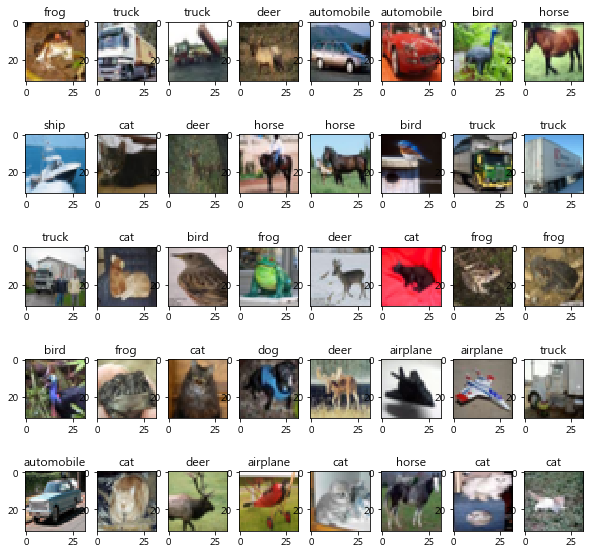

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(10, 10))
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(0, 40): # 0 ~ 39
    im = Image.fromarray(X_train[i])  # NumPy 배열을 Image 객체로 변환
    plt.subplot(5, 8, i + 1)               # 5행 8열의 구성중에 출력할 이미지 번호(1~40)
    plt.title(labels[Y_train[i][0]]) # 2차원 배열, labels 배열에서 class를 문자열로 변환, 6->frog 
    plt.tick_params(labelbottom="off",bottom="off") # x축 제거
    plt.tick_params(labelleft="off",left="off") # y축 제거
    plt.imshow(im)

plt.show()

In [5]:
num_classes = 10 # class 10 사용
im_rows = 32
im_cols = 32
# 1024*3 =3072, 칼라 이미지, 하나의 이미지를 표현하기위해 3072개의 변수 필요
im_size = im_rows * im_cols * 3  

# 데이터 읽어 들이기 
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape) # (50000, 32, 32, 3)

(50000, 32, 32, 3)


In [6]:
# 4차원 배열을 2차원 배열로 변환하기 
x_train = X_train.reshape(-1, im_size).astype('float32') / 255 # (50000, 3072)
x_test = X_test.reshape(-1, im_size).astype('float32') / 255
print(x_train.shape) # (50000, 3072)

(50000, 3072)


In [7]:
# 레이블 데이터를 One-hot 형식(0, 1의 조합으로 그룹화)으로 변환하기
y_train = to_categorical(Y_train, num_classes)
y_test = to_categorical(Y_test, num_classes)

print(y_train[0]) # frog -> 6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] index 6의 지점을 나타냄

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [8]:
# 모델 정의하기 
model = Sequential()
model.add(Dense(3072, activation='relu', input_shape=(im_size,)))  # 3072
model.add(Dense(512, activation='relu')) 
model.add(Dense(256, activation='relu')) 
model.add(Dense(100, activation='relu')) 
model.add(Dense(50, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) # 종류가 10개임으로 출력도 10

# 모델 컴파일하기 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
# 학습을 하지 않아도 파라미터 확인 가능
# 전결합층은 파라미터(변수)의 갯수가 1000만개를 넘어가면 속도가 매우 떨어짐.
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 11,176,220
Trainable params: 11,176,220
Non-trainable params: 0
________________________________________________________________

In [10]:
# 모델 정의하기
# 전결합층은 이미지 처리에서 시간이 많이 소모되고 학습 정확도도 늦게 향상됨.
# 검증 정확도: 49%
model = Sequential()
model.add(Dense(3072, activation='relu', input_shape=(im_size,)))  # 3072
model.add(Dense(512, activation='relu')) 
model.add(Dense(256, activation='relu')) 
model.add(Dense(100, activation='relu')) 
model.add(Dense(50, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) # 종류가 10개임으로 출력도 10

# 모델 컴파일하기 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
start = time.time()
# 학습 실행하기, verbose=1 진행 사항 출력, 0은 출력 안함.
hist = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=1,
    validation_data=(x_test, y_test))

end = time.time()

print('Runtime: %0.2f 초' % (end-start))
# CPU: 약 5500 s
# GPU: 268 s , Colab GPU: 200 s, Colab,  TPU:  

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 107s 2ms/step - loss: 1.9515 - acc: 0.2725 - val_loss: 1.8027 - val_acc: 0.3386
Epoch 2/10
50000/50000 [==============================] - 105s 2ms/step - loss: 1.7764 - acc: 0.3520 - val_loss: 1.7371 - val_acc: 0.3672
Epoch 3/10
50000/50000 [==============================] - 105s 2ms/step - loss: 1.6925 - acc: 0.3874 - val_loss: 1.6405 - val_acc: 0.4133
Epoch 4/10
50000/50000 [==============================] - 105s 2ms/step - loss: 1.6378 - acc: 0.4091 - val_loss: 1.6221 - val_acc: 0.4156
Epoch 5/10
50000/50000 [==============================] - 105s 2ms/step - loss: 1.5962 - acc: 0.4264 - val_loss: 1.5928 - val_acc: 0.4303
Epoch 6/10
50000/50000 [==============================] - 104s 2ms/step - loss: 1.5684 - acc: 0.4375 - val_loss: 1.6145 - val_acc: 0.4247
Epoch 7/10
50000/50000 [==============================] - 107s 2ms/step - loss: 1.5482 - acc: 0.4446 - val_loss: 1.5498 - 

NameError: name 'end' is not defined

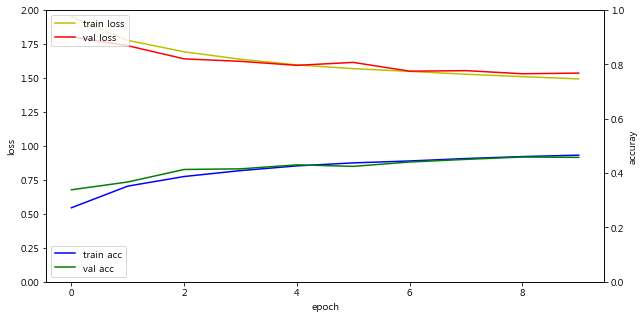

In [11]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

loss_ax.plot(hist.history['loss'], 'y', label='train loss')   # 훈련 손실
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 검증 손실, 학습의 우수성 평가 척도
loss_ax.set_ylim([0.0, 2.0]) # 왼쪽 y 축, 값을 반영하여 변경

acc_ax.plot(hist.history['acc'], 'b', label='train acc')   # 훈련 정확도
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc') # 검증 정확도
acc_ax.set_ylim([0.0, 1.0])  # 오른쪽 y 축, 0 ~100 %를 의미

loss_ax.set_xlabel('epoch')  # x축 레이블
loss_ax.set_ylabel('loss')     # 왼쪽 y 레이블
acc_ax.set_ylabel('accuray') # 오른쪽 y 레이블

loss_ax.legend(loc='upper left')  # 좌측 y 축 기준 범례 위치 설정
acc_ax.legend(loc='lower left')   # 우측 y 축 기준 범례 위치 설정

plt.show()


In [15]:
model.save('./cifar10_mlp.h5')

In [12]:
# OpenCV를 사용해서 이미지 읽어 들이기
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np

model = load_model('./cifar10_mlp.h5')

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = 10 # class 10 사용
im_rows = 32
im_cols = 32
im_size = im_rows * im_cols * 3  

# local gpu
# im = cv2.imread('./k3.jpg')    # automobile
im = cv2.imread('./sonata.jpg')   # automobile
# im = cv2.imread('./avante.jpg')   # Truck

# gcp, 절대 경로 사용
# im = cv2.imread('./drive/My Drive/Colab Notebooks/k3.jpg')    # automobile
# im = cv2.imread('./drive/My Drive/Colab Notebooks/avante.jpg')     # automobile
# im = cv2.imread('./drive/My Drive/Colab Notebooks/sonata.jpg')     # automobile

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # BGR --> RGB로 변환
im = cv2.resize(im, (32, 32))
plt.imshow(im) # 이미지 출력하기
plt.show()

# MLP로 학습한 이미지 데이터에 형태 맞추기
im = im.reshape(im_size).astype('float32') / 255

error: C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:9716: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


In [ ]:
#
#


In [ ]:
# 예측하기 np.array([im]) : [[im]]의 2차원 형태로 전달해야 함.
r = model.predict(np.array([im]), batch_size=32, verbose=1)
print(r)
res = r[0] # 2차원임으로 첫번째 행만 추출

# 결과 출력하기
for i, acc in enumerate(res):
    print(labels[i], "=", int(acc * 100), '%')  # i : 인덱스, acc : 값
print("-------------")
print("예측한 결과=", labels[res.argmax()])